# Multidimensional Scaling in Hyperbolic Space

In this notebook, I begin my attempt to implement a Multidimensional Scaling (MDS) algorithm that embeds data into hyperbolic space instead of the target Euclidean space for standard MDS. Just like traditional MDS, this variant h-MDS (hyperbolic MDS) will seek to produce accurate spatial representations of possibly high dimensional datasets, by  attempting to reflect the original pairwise similarities by the corresponding pairwise distances of the output configuration in the embedding space. <br>
<br>
Relevant papers that discuss hyperbolic MDS and outline some general implementation details: <br>
<br>
[1]. A. Cvetkovski and M. Crovella. Multidimensional scaling in the Poincaré disk. arXiv:1105.5332, 2011.<br>
[2]. H-MDS: a new approach for interactive visualization with multidimensional scaling in the hyperbolic space. Jörg Walter. Information Systems, Elsevier, 29(4):273-292, 2004.<br>
[3]. Jörg A. Walter and Helge Ritter. 2002. On interactive visualization of high-dimensional data using the hyperbolic plane. In Proceedings of the eighth ACM SIGKDD international conference on Knowledge discovery and data mining (KDD '02). ACM, New York, NY, USA, 123-132. DOI=http://dx.doi.org/10.1145/775047.775065

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
from sklearn.utils import check_random_state
#plt.style.use('classic')
#plt.rcParams['figure.figsize'] = (6.5, 6.5)
#plt.rcParams['figure.facecolor'] = 'white'
#from jupyterthemes import jtplot
#jtplot.style()

# ignore warnings
import warnings
warnings.filterwarnings('ignore');

# display multiple outputs within a cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all";

# Intro and key concepts

We use the Poincaré disk as our model of hyperbolic space, and the only fundamental change with respect to MDS in Euclidean space is that we need to use the Poincaré distance metric instead of the Euclidean distance.

We can define the Poincare disk based on the complex plane: $\mathbb{D}=\{z \in \mathbb{C}| | z |<1\}$. We have the symmetric distance function for $\boldsymbol{u}, \boldsymbol{v} \in \mathcal{D}$:

$$
d(\boldsymbol{u}, \boldsymbol{v})=\operatorname{arcosh}\left(1+2 \frac{\|\boldsymbol{u}-\boldsymbol{v}\|^{2}}{\left(1-\|\boldsymbol{u}\|^{2}\right)\left(1-\|\boldsymbol{v}\|^{2}\right)}\right)
$$ <br>
<br>
or considering the complex plane: <br>
$$
d_{\mathbb{D}}\left(z_{j}, z_{k}\right)=2 \operatorname{atanh} \frac{\left|z_{j}-z_{k}\right|}{\left|1-z_{j} \overline{z}_{k}\right|}
$$

The idea of Mobius transformations will also be important, and these are transformations that preserve hyperbolic distances. The Mobius transformations $T$ have the following form: <br> 
<br>
$$
T(z)=\frac{a z+b}{\overline{b} z+\overline{a}}, a, b \in \mathbb{C},|a|^{2}-|b|^{2} \neq 0
$$

Our h-MDS algorithm will have a relatively simple design based on iterative steepest descent and an approximate line search function. Therefore, we need to be able to describe hyperbolic lines based on a given direction $\gamma$ and a starting point $z_0$. For $z_{0} \in \mathbb{D}, \gamma \in \mathbb{C}$ with $|\gamma|=1,$ and $s \geq 0$, this hyperbolic line is given by:<br>
<br>
$$
z_{0}^{\prime}=\frac{\gamma \tanh \frac{s}{2}+z_{0}}{\overline{z_{0}} \gamma \tanh \frac{s}{2}+1}
$$ <br>
where $s$ gives the length along the line and $d_{\mathrm{D}}\left(z_{0}, z_{0}^{\prime}\right)=s$

# Gradient descent and hyperbolic line search

## Descent method

The steepest descent will be based on the gradient of an objective function $E_t(\mathbf{z}, \Delta, \mathbf{W}, \mathbf{I})$ that is defined by these inputs and which gives the embedding error or loss at some given iteration $t$<br>
<br>
One common embedding error is given by the following function defined as the sum of relative squared differences between the initial dissimilarities and the distances in the embedding space:. <br>
<br>
$$
E_{t}(\mathbf{z}, \Delta, \mathbf{W}, \mathbf{I})=\sum_{j=1}^{n} \sum_{k=j+1}^{n} w_{j k} I_{j k}\left(\frac{d_{j k}(t)-\delta_{j k}}{\delta_{j k}}\right)^{2}
$$

The descent direction is defined by the gradient of this error function: <br>
<br>
$$
\mathbf{g}=\nabla E \stackrel{\mathrm{def}}{=}\left[\begin{array}{c}{\frac{\partial E}{\partial y_{1,1}}+i \frac{\partial E}{\partial y_{1,2}}} \\ {\frac{\partial E}{\partial y_{2,1}}+i \frac{\partial E}{\partial y_{2,2}}} \\ {\vdots} \\ {\frac{\partial E}{\partial y_{n, 1}}+i \frac{\partial E}{\partial y_{n, 2}}}\end{array}\right]=\left[\begin{array}{c}{g_{1}} \\ {g_{2}} \\ {\vdots} \\ {g_{n}}\end{array}\right]
$$<br>
We have descent directions $-g_1, \ldots , -g_n$ and the new configuration after the update will have points <br>
<br>
$$
z_{j}^{\prime}=\frac{-r g_{j}+z_{j}}{-r g_{j} \overline{z_{j}}+1}
$$ <br>
and $r \geq 0$ is the step-size parameter

![title](images/pd_mds5.png) <br>
source: A. Cvetkovski and M. Crovella. Multidimensional scaling in the Poincaré disk

## Approximate Hyperbolic Line Search

We have some more notation and parameters related to line search. $s_M$ sets the window for distance between successive configurations or updates. We need this to be finite to limit points from approaching the boundary at infinite distances. If $s_j$ are distances for updates: $s_{M}=\max _{j} s_{j}<\infty$<br>
<br>
The parameter $r_M$ sets the window for the step size $r$ and we restrict our line search for each update within this window. We have the constraint: $r<\frac{1}{\|\mathbf{g}\|_{\infty}}$ and the following equation that relates these parameters: <br>

$$
r_{M}=\frac{1}{\|\mathbf{g}\|_{\infty}} \cdot \tanh \frac{s_{M}}{2}<\frac{1}{\|\mathbf{g}\|_{\infty}}
$$

During our line search, it would be ideal to find the step size $r$ along the hyperbolic line (but within the window $r_M$) that minimizes the error function. This turns out to be too computationally expensive, and so we just set a sufficient stopping condition and accept any step size that meets the condition. 

To express the stopping condition, we define the error in terms of the step size and let this function be $q(r)$ <br>
<br>
We also define this 'roof' function: $\lambda(r)=q(0)+p \cdot q^{\prime}(0) \cdot r, \quad 0<p<1$ <br>
<br>
and set the condition for acceptable values of step size: $q(r)<\lambda(r), r \in\left(0, r_{M}\right]$ 

![title](images/line_search.png) <br>
source: A. Cvetkovski and M. Crovella. Multidimensional scaling in the Poincaré disk

We need to find explicit formulas for $q(r)$ and its derivative $q'(r)$ in order to calculate these values and apply the stopping conditions in the approximate line search. <br>
<br>
We can write the updates for each $z_j$ based on the Mobius transformations: $M_{j}(r)=\frac{-r g_{j}+z_{j}}{-r g_{j} \overline{z}_{j}+1}$

The expression for the error in terms of step size can now be written as $q(r)=E(\mathbf{M}(-r \mathbf{g}, \mathbf{z}), \mathbf{\Delta}, \mathbf{W}, \mathbf{I})$ <br>
<br>
$q'(r)$ has the following form: <br>
<br>
$$
\begin{aligned} q^{\prime}(r) &=\frac{d}{d r} q(r)=\\ &=\left(\operatorname{Re} \mathbf{M}^{\prime}(-r \mathbf{g}, \mathbf{z})\right)^{T} \operatorname{Re} \nabla E(\mathbf{M}(-r \mathbf{g}, \mathbf{z}), \boldsymbol{\Delta}, \mathbf{W}, \mathbf{I}) \\ &+\left(\operatorname{Im} \mathbf{M}^{\prime}(-r \mathbf{g}, \mathbf{z})\right)^{T} \operatorname{Im} \nabla E(\mathbf{M}(-r \mathbf{g}, \mathbf{z}), \boldsymbol{\Delta}, \mathbf{W}, \mathbf{I}) \end{aligned}
$$

and this can be explicitly calculated using the following equation: <br>
<br>
$$
M_{j}^{\prime}(r)=\frac{d}{d r} M_{j}(r)=g_{j} \frac{\left|z_{j}\right|^{2}-1}{\left(1-r g_{j} \overline{z_{j}}\right)^{2}}
$$

![title](images/hyp_line.png) <br>
source: A. Cvetkovski and M. Crovella. Multidimensional scaling in the Poincaré disk

# Deriving gradients to implement h-MDS

For the initial implementation of h-MDS let the error function be given by the Absolute Differences Squared (ADS) <br>
<br>
$$
E=\sum_{j=1}^{n} \sum_{k=j+1}^{n} w_{j k}\left(I_{j k}\left(d_{j k}-a \delta_{j k}\right)\right)^{2}
$$ <br>
$W$ is a weight matrix and $I$ is an indicator matrix for sparse/missing values in dissimilarity matrix <br>
$d_{j k}$ is the distance in the poincaré disk and $\delta_{j k}$ is the original dissimilarity <br>
<br>
Hyperbolic distance is not scale invariant like Euclidean distance, so we have an additional degree of freedom $\alpha$ - a scaling factor for the original entries of dissimilarity matrix

We need to find the gradient of the error function $E$ <br>
<br>
$$
\nabla E \stackrel{\mathrm{def}}{=}\left[\begin{array}{c}{\frac{\partial E}{\partial y_{1,1}}+i \frac{\partial E}{\partial y_{1,2}}} \\ {\frac{\partial E}{\partial y_{2,1}}+i \frac{\partial E}{\partial y_{2,2}}} \\ {\vdots} \\ {\frac{\partial E}{\partial y_{n, 1}}+i \frac{\partial E}{\partial y_{n, 2}}}\end{array}\right]
$$ <br>
<br>
Using the chain rule: <br>
$$
\nabla E=\frac{\partial E (z_i)}{\partial d(z_i, z_j)} \frac{\partial d(z_i, z_j)}{\partial z_i}
$$

The first partial derivative term for the loss function is given by:<br>
<br>
$$\frac{\partial E (z_i)}{\partial d(z_i, z_j)} = w_{i j} (2 d(z_i, z_j) - 2 \alpha \delta_{i j})$$

For the partial derivatives of the poincaré distance, consider two ways to define the distance function<br>
<br>
For the arccosh definition, define the following:<br>
$$
\alpha=1-\|z_i\|^{2}
$$
$$
\beta=1-\|z_j\|^{2}
$$
$$
\gamma=1+\frac{2}{\alpha \beta}\|z_i-z_j\|^{2}
$$

and we can write the partial derivative<br>
<br>
$$
\frac{\partial d(z_i, z_j)}{\partial z_i}=\frac{4}{\beta \sqrt{\gamma^{2}-1}}\left(\frac{\|z_j\|^{2}-2\langle z_i, z_j\rangle+ 1}{\alpha^{2}} z_i-\frac{z_j}{\alpha}\right)
$$

For the arctanh definition, we have: <br>
<br>
$$
\begin{aligned} \frac{\partial}{\partial x_{i, 1}} d\left(\mathbf{x}_{i}, \mathbf{x}_{j}\right) &=\frac{2 t}{1-t^{2}}\left(\frac{v_{1}}{v_{1}^{2}+v_{2}^{2}}-\frac{x_{j, 1} v_{3}+x_{j, 2} v_{4}}{v_{3}^{2}+v_{4}^{2}}\right) \\ \frac{\partial}{\partial x_{i, 2}} d\left(\mathbf{x}_{i}, \mathbf{x}_{j}\right) &=\frac{2 t}{1-t^{2}}\left(\frac{v_{2}}{v_{1}^{2}+v_{2}^{2}}+\frac{x_{i, 1} v_{4}-x_{j, 2} v_{3}}{v_{3}^{2}+v_{4}^{2}}\right) \end{aligned}
$$

with the following definitions of these terms: <br>

$$
\begin{aligned} \mathbf{x}_{i} &=\left(x_{i, 1}+\mathrm{i} x_{i, 2}\right) \in P D \subset \mathbb{C} \\ \mathbf{x}_{j} &=\left(x_{j, 1}+\mathrm{i} x_{j, 2}\right) \in P D \subset \mathbb{C} \\ v_{1} &=x_{i, 1}-x_{j, 1} \\ v_{3} &=x_{i, 1} x_{j, 1}+x_{i, 2} x_{j, 2}-1 \\ v_{2} &=x_{i, 2}-x_{j, 2} \\ v_{4} &=x_{i, 1} x_{j, 2}-x_{j, 1} x_{i, 2} \\ t^{2} &=\frac{v_{1}^{2}+v_{2}^{2}}{v_{3}^{2}+v_{4}^{2}} \end{aligned}
$$

and finally we have an explicit form of the gradient $\nabla E$

# Python/Numpy Implementation

In [229]:
def norm(x, axis=None):
    return np.linalg.norm(x, axis=axis)

def poincare_dist(u, v, eps=1e-3):
    d = 1 + 2 * norm(u-v)**2 / ((1 - norm(u)**2) * (1 - norm(v)**2) + eps)
    return np.arccosh(d)

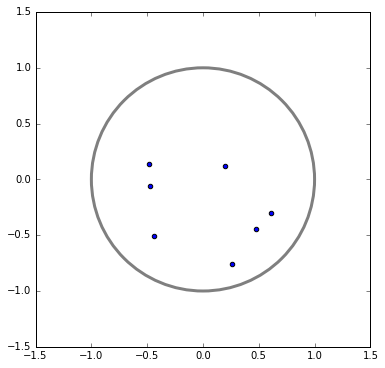

In [233]:
# generate a small set of random points in poincaré disk
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)
circ = plt.Circle((0, 0), radius=1, edgecolor='black', facecolor='None', linewidth=3, alpha=0.5)
ax.add_patch(circ)

# sample within unit sphere in R^2
n = 7
theta = np.random.uniform(0, 2*np.pi, n)
u = np.random.uniform(0, 0.7, n)
r = np.sqrt(u)
x = r * np.cos(theta)
y = r * np.sin(theta)
init_data = np.hstack((x.reshape(-1,1), y.reshape(-1,1)))
ax.scatter(x, y, s=20, alpha=1);

In [234]:
dissimilarity = np.zeros((n, n))
for i in range(n):
    for j in range(n):
        dissimilarity[i][j] = poincare_dist(init_data[i], init_data[j])
dissimilarity

array([[0.        , 1.49844596, 3.06723216, 2.14734227, 2.38523281,
        2.79876071, 2.5351527 ],
       [1.49844596, 0.        , 2.59712454, 0.68993344, 1.54510347,
        2.42456298, 2.50722729],
       [3.06723216, 2.59712454, 0.        , 2.75364202, 1.47858533,
        0.5033803 , 1.76047754],
       [2.14734227, 0.68993344, 2.75364202, 0.        , 1.51430649,
        2.63044551, 2.84532709],
       [2.38523281, 1.54510347, 1.47858533, 1.51430649, 0.        ,
        1.49134996, 2.07657232],
       [2.79876071, 2.42456298, 0.5033803 , 2.63044551, 1.49134996,
        0.        , 1.2866769 ],
       [2.5351527 , 2.50722729, 1.76047754, 2.84532709, 2.07657232,
        1.2866769 , 0.        ]])

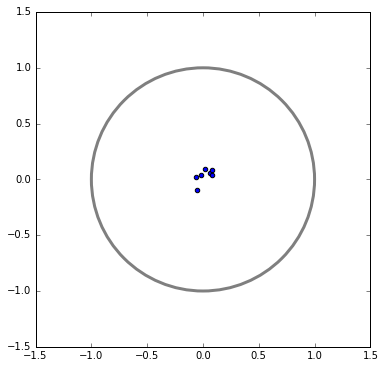

In [236]:
def init_z(n, dim=2, low=-0.1, high=0.1):
    random_config = np.random.uniform(low, high, size=(n, dim))
    return random_config

# plot initial random configuration
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)
circ = plt.Circle((0, 0), radius=1, edgecolor='black', facecolor='None', linewidth=3, alpha=0.5)
ax.add_patch(circ)

init_config = init_z(7)
x = init_config[:,0]
y = init_config[:,1]
ax.scatter(x, y, s=20, alpha=1);

In [226]:
eps = 1e-3
def partial_d(theta, x):
    alpha = 1 - norm(theta)**2
    beta = 1 - norm(x)**2
    gamma = 1 + 2/(alpha*beta + eps) * norm(theta-x)**2
    lhs = 4 / (beta*np.sqrt(gamma**2 - 1) + eps)
    rhs = 1/(alpha**2 + eps) * (norm(x)**2 - 2*np.inner(theta,x) + 1) * theta - x/(alpha + eps)
    return lhs*rhs

def proj(theta):
    if norm(theta) >= 1:
        theta = theta/norm(theta) - eps
    return theta

In [228]:
def loss_fn(embed_config, dissimilarities, n, alpha=4):
    loss = 0
    for i in range(n):
        for j in range(i+1, n):
            zi_error = (poincare_dist(embed_config[i], embed_config[j]) - alpha*dissimilarities[i][j])**2
            loss += zi_error
    return loss
loss_fn(init_config, dissimilarity, n=len(init_config))

def compute_gradients(Z, dissimilarities, n, alpha=4):
    gradients = np.zeros((n, 2))
    for i in range(n):
        grad_zi = 0
        for j in range(n):
            dd_loss = 2*poincare_dist(Z[i], Z[j]) - 2*alpha*dissimilarities[i][j]
            dd_dist = partial_d(Z[i], Z[j])
            grad_zi += dd_loss * dd_dist
        gradients[i] = grad_zi
    return gradients
compute_gradients(init_config, dissimilarity, len(init_config))

def conjugate(z):
    z_bar = np.array([z[0], -z[1]])
    return z_bar
conjugate([1, 2])

1435.3012491449626

array([[ -89.44718579, -119.24026763],
       [ 113.79415022,  -37.73945464],
       [  33.38595003,  125.68209546],
       [ 171.64273573,    6.2389917 ],
       [ -56.86648641, -125.5557056 ],
       [ -91.76179579,  103.14772668],
       [ -80.96342566,   44.10551487]])

array([ 1, -2])

We only need to compute the derivative of q(r) evaluated at 0, so here we just plug 0 into q'(r) <br>
<br>
$$
\begin{aligned} q^{\prime}(0) &=\frac{d}{d r} q(0)\\ &=\left(\operatorname{Re} \mathbf{M}^{\prime}(-r \mathbf{g}, \mathbf{z})\right)^{T} \operatorname{Re} \nabla E(\mathbf{M}(-r \mathbf{g}, \mathbf{z}), \boldsymbol{\Delta}, \mathbf{W}, \mathbf{I}) \\ &+\left(\operatorname{Im} \mathbf{M}^{\prime}(-r \mathbf{g}, \mathbf{z})\right)^{T} \operatorname{Im} \nabla E(\mathbf{M}(-r \mathbf{g}, \mathbf{z}), \boldsymbol{\Delta}, \mathbf{W}, \mathbf{I}) \end{aligned}
$$ <br>
with step size = 0 we also have: <br>
$$
M_{j}(0)=z_j
$$<br>
$$
M_{j}^{\prime}(0)=g_{j} (\left|z_{j}\right|^{2}-1)
$$

In [198]:
def q(r, Z, g, dissimilarities, n):
    M_r = np.zeros((n, 2))
    for j in range(n):
        M_r[j] = (-r*g[j] + Z[j]) / (-r*g[j] * conjugate(Z[j]) + 1)
    return loss_fn(M_r, dissimilarities, n)

In [222]:
def line_search(Z, dissimilarities, n, r0, rmax):
    Z_norm = norm(Z, axis=1)**2
    g = -compute_gradients(Z, dissimilarity, n)
    M_prime = g*Z_norm.reshape(-1,1)
    qprime_0 = np.dot(M_prime[:,0].T, g[:,0]) + np.dot(M_prime[:,1].T, g[:,1])
    p=0.1
    roof_fn = lambda r: q(0, Z, g, dissimilarities, n) + p*qprime_0*r
    r = r0
    rmin = 1e-5
    while rmin < r < rmax and q(r, Z, g, dissimilarities, n) < roof_fn(r):
        print(r)
        r = 2*r
    while rmin < r < rmax or q(r, Z, g, dissimilarities, n) > roof_fn(r):
        print(r)
        r = r/2
    return r
line_search(init_config, dissimilarity, len(init_config), 0.1, 0.5)

0.4
0.2
0.1
0.05
0.025
0.0125
0.00625
0.003125
0.0015625
0.00078125
0.000390625
0.0001953125
9.765625e-05
4.8828125e-05
2.44140625e-05
1.220703125e-05


6.103515625e-06

In [208]:
def descent_method(init, dissimilarities, n_components=2, max_iter = 100, verbose=0, alpha=4,
                   weights=None, indicators=None):
    #error_tol =
    #min_grad = 
    #min_step = 
    Z = init
    n = len(Z)
    smax = 10
    for i in range(2):
        current_loss = loss_fn(Z, dissimilarities, n)
        g = compute_gradients(Z, dissimilarities, n)
        rmax = 1/(norm(g, axis=1).max()+eps) * np.tanh(smax/2)
        r = line_search(Z, dissimilarities, n, 0.1, rmax)
        for i in range(n):
            zi_prime = (-r*g[i] + Z[i]) / (-r*g[i] * conjugate(Z[i]) + 1)
            Z[i] = zi_prime
    return Z
descent_method(init_config, dissimilarity)

array([[ 8.72778011e+00, -4.32544128e+00],
       [-7.62588481e+00, -1.33009726e+02],
       [ 8.44340657e+00, -1.39019543e+00],
       [-2.24557534e-01, -1.90861822e+01],
       [-3.36175443e-01,  2.52333828e-03],
       [-2.10198164e+01, -1.63824466e+00],
       [-6.19468541e+00,  1.20324128e+01]])

In [ ]:
class HyperMDS():
    
    def __init__(self, n_components=2, max_iter=100, verbose=0, eps=1e-3, n_jobs=None,
                 random_state=None, dissimilarity="euclidean"):
        self.n_components = n_components
        self.dissimilarity = dissimilarity
        self.max_iter = max_iter
        self.eps = eps
        self.verbose = verbose
        self.n_jobs = n_jobs
        self.random_state = random_state
    
    def fit(self, X, init=None):
        """
        Uses gradient descent to find the embedding configuration in the Poincaré disk
        Parameters
        ----------
        X : array, shape (n_samples, n_features) or (n_samples, n_samples)
            Input data. If ``dissimilarity=='precomputed'``, the input should
            be the dissimilarity matrix.
        init: initial configuration of the embedding coordinates
        """
        self.fit_transform(X, init=init)
        return self
    
    def fit_transform(self, X, init=None):
        """
        Fit the embedding from X, and return the embedding coordinates
        Parameters
        ----------
        X : array, shape (n_samples, n_features) or (n_samples, n_samples)
            Input data. If ``dissimilarity=='precomputed'``, the input should
            be the dissimilarity matrix.
        init: initial configuration of the embedding coordinates
        """

In [1]:
from IPython.core.display import HTML

def css_styling():
    styles = open("custom_style.css", "r").read()
    return HTML(styles)
css_styling()